# Set up and Read in Data

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import random 

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
data = pd.read_csv("/data.csv")

In [ ]:
data.head(5)

,Unnamed: 0,text,role,movie_clean,mbti
0,0,They do not!,Bianca Stratford,10 things i hate about you,ESFJ
1,1,They do to!,Cameron James,10 things i hate about you,INFP
2,2,I hope so.,Bianca Stratford,10 things i hate about you,ESFJ
3,3,She okay?,Cameron James,10 things i hate about you,INFP
4,4,Let's go.,Bianca Stratford,10 things i hate about you,ESFJ


In [ ]:
cleaned_data = data[data["mbti"] != 'XXXX']

# Distribution of MBTI Types
Code adapted from https://github.com/stefan-bergstein/NLP-and-ML-on-Myers-Briggs-Personality-Type-Dataset/blob/master/mbti-notebook.ipynb

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


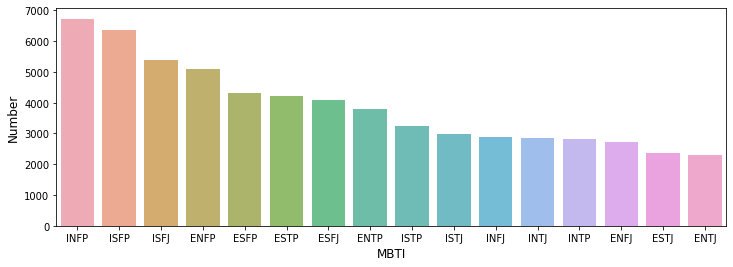

In [ ]:
mbti_types = cleaned_data['mbti'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(mbti_types.index, mbti_types.values, alpha=0.8)
plt.ylabel('Number', fontsize=12)
plt.xlabel('MBTI', fontsize=12)
plt.show()

In [ ]:
def get_types(row):
    t=row['mbti']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E incorrect')
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S incorrect')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F incorrect')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P incorrect')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

cleaned_data = cleaned_data.join(cleaned_data.apply (lambda row: get_types (row),axis=1))
cleaned_data.head(5)

,Unnamed: 0,text,role,movie_clean,mbti,IE,NS,TF,JP
0,0,They do not!,Bianca Stratford,10 things i hate about you,ESFJ,0,0,0,1
1,1,They do to!,Cameron James,10 things i hate about you,INFP,1,1,0,0
2,2,I hope so.,Bianca Stratford,10 things i hate about you,ESFJ,0,0,0,1
3,3,She okay?,Cameron James,10 things i hate about you,INFP,1,1,0,0
4,4,Let's go.,Bianca Stratford,10 things i hate about you,ESFJ,0,0,0,1


In [ ]:
print ("Introversion (I) /  Extroversion (E):\t", cleaned_data['IE'].value_counts()[0], " / ", cleaned_data['IE'].value_counts()[1])
print ("Intuition (N) – Sensing (S):\t\t", cleaned_data['NS'].value_counts()[0], " / ", cleaned_data['NS'].value_counts()[1])
print ("Thinking (T) – Feeling (F):\t\t", cleaned_data['TF'].value_counts()[0], " / ", cleaned_data['TF'].value_counts()[1])
print ("Judging (J) – Perceiving (P):\t\t", cleaned_data['JP'].value_counts()[0], " / ", cleaned_data['JP'].value_counts()[1])

Introversion (I) /  Extroversion (E):	 28845  /  33218
Intuition (N) – Sensing (S):		 32912  /  29151
Thinking (T) – Feeling (F):		 37544  /  24519
Judging (J) – Perceiving (P):		 36546  /  25517


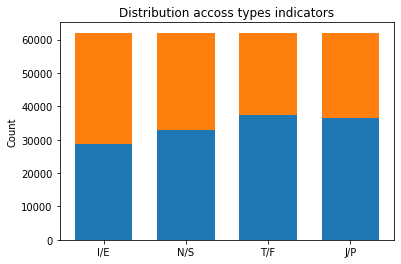

In [ ]:
N = 4
but = (cleaned_data['IE'].value_counts()[0], cleaned_data['NS'].value_counts()[0], cleaned_data['TF'].value_counts()[0], cleaned_data['JP'].value_counts()[0])
top = (cleaned_data['IE'].value_counts()[1], cleaned_data['NS'].value_counts()[1], cleaned_data['TF'].value_counts()[1], cleaned_data['JP'].value_counts()[1])

ind = np.arange(N)    # the x locations for the groups
width = 0.7      # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, but, width)
p2 = plt.bar(ind, top, width, bottom=but)

plt.ylabel('Count')
plt.title('Distribution accoss types indicators')
plt.xticks(ind, ('I/E',  'N/S', 'T/F', 'J/P',))

plt.show()

## Split Into Train/Val/Test

In [ ]:
# Divide data into train/test split based on movie character.
unique_roles = list(cleaned_data["role"].unique())

random.seed(100)
val_roles = random.sample(unique_roles, round(len(unique_roles)*0.1))

remaining_roles = [role for role in unique_roles if role not in val_roles]
test_roles = random.sample(remaining_roles, round(len(unique_roles)*0.1))

train_roles = [role for role in remaining_roles if role not in test_roles]

In [ ]:
df_train = cleaned_data[cleaned_data["role"].isin(train_roles)]
df_val = cleaned_data[cleaned_data["role"].isin(val_roles)]
df_test = cleaned_data[cleaned_data["role"].isin(test_roles)]

In [ ]:
# Print number in each group.
print("Training: ", len(df_train))
print("Val: ", len(df_val))
print("Test: ", len(df_test))

Training:  50971
Val:  6471
Test:  4621


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


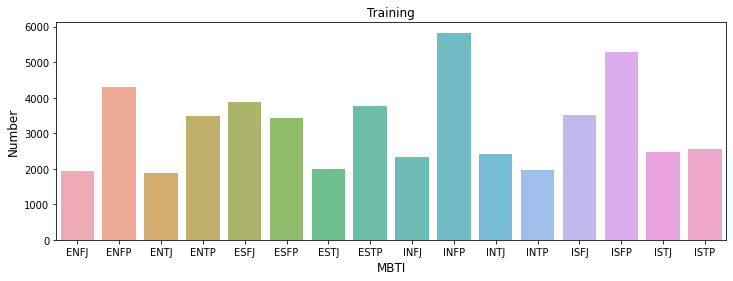

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


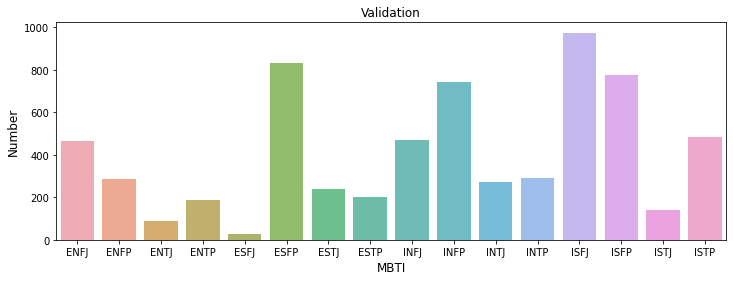

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


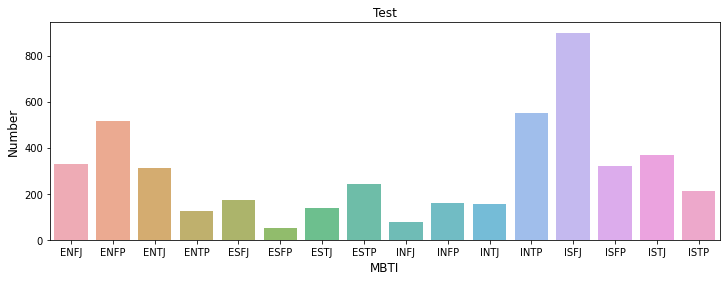

In [ ]:
df_train_mbti_types = df_train['mbti'].value_counts().sort_index()

plt.figure(figsize=(12,4))
sns.barplot(df_train_mbti_types.index, df_train_mbti_types.values, alpha=0.8)
plt.ylabel('Number', fontsize=12)
plt.xlabel('MBTI', fontsize=12)
plt.title("Training")
plt.show()

df_val_mbti_types = df_val['mbti'].value_counts().sort_index()

plt.figure(figsize=(12,4))
sns.barplot(df_val_mbti_types.index, df_val_mbti_types.values, alpha=0.8)
plt.ylabel('Number', fontsize=12)
plt.xlabel('MBTI', fontsize=12)
plt.title("Validation")
plt.show()

df_test_mbti_types = df_test['mbti'].value_counts().sort_index()

plt.figure(figsize=(12,4))
sns.barplot(df_test_mbti_types.index, df_test_mbti_types.values, alpha=0.8)
plt.ylabel('Number', fontsize=12)
plt.xlabel('MBTI', fontsize=12)
plt.title("Test")
plt.show()

In [ ]:
# Gets the proportion of mbti within each group for train dataset.
train_mbti_proportion = df_train.groupby("mbti").count().sort_values("role", ascending=False) / df_train.count()
train_mbti_proportion

,IE,JP,NS,TF,Unnamed: 0,mbti,movie_clean,role,text
mbti,,,,,,,,,
INFP,0.114340,0.114340,0.114340,0.114340,0.114340,NaN,0.114340,0.114340,0.114333
ISFP,0.103471,0.103471,0.103471,0.103471,0.103471,NaN,0.103471,0.103471,0.103483
ENFP,0.084166,0.084166,0.084166,0.084166,0.084166,NaN,0.084166,0.084166,0.084175
ESFJ,0.076181,0.076181,0.076181,0.076181,0.076181,NaN,0.076181,0.076181,0.076190
ESTP,0.073924,0.073924,0.073924,0.073924,0.073924,NaN,0.073924,0.073924,0.073933
ISFJ,0.068666,0.068666,0.068666,0.068666,0.068666,NaN,0.068666,0.068666,0.068675
ENTP,0.068137,0.068137,0.068137,0.068137,0.068137,NaN,0.068137,0.068137,0.068106
ESFP,0.067097,0.067097,0.067097,0.067097,0.067097,NaN,0.067097,0.067097,0.067085
ISTP,0.049930,0.049930,0.049930,0.049930,0.049930,NaN,0.049930,0.049930,0.049917


In [ ]:
# Gets the proportion of mbti within each group for test dataset.
test_mbti_proportion = df_test.groupby("mbti").count().sort_values("role", ascending=False) / df_test.count()
test_mbti_proportion

,IE,JP,NS,TF,Unnamed: 0,mbti,movie_clean,role,text
mbti,,,,,,,,,
ISFJ,0.194547,0.194547,0.194547,0.194547,0.194547,NaN,0.194547,0.194547,0.194547
INTP,0.119238,0.119238,0.119238,0.119238,0.119238,NaN,0.119238,0.119238,0.119238
ENFP,0.111448,0.111448,0.111448,0.111448,0.111448,NaN,0.111448,0.111448,0.111448
ISTJ,0.079420,0.079420,0.079420,0.079420,0.079420,NaN,0.079420,0.079420,0.079420
ENFJ,0.070764,0.070764,0.070764,0.070764,0.070764,NaN,0.070764,0.070764,0.070764
ISFP,0.069682,0.069682,0.069682,0.069682,0.069682,NaN,0.069682,0.069682,0.069682
ENTJ,0.067518,0.067518,0.067518,0.067518,0.067518,NaN,0.067518,0.067518,0.067518
ESTP,0.052153,0.052153,0.052153,0.052153,0.052153,NaN,0.052153,0.052153,0.052153
ISTP,0.046310,0.046310,0.046310,0.046310,0.046310,NaN,0.046310,0.046310,0.046310


## Preprocess Text (Convert to Vector)

In [ ]:
# Lemmatize, remove stopwords, lowercase, but breaks into unigrams and bigrams.
# Code adapted from https://stackoverflow.com/questions/50155188/lemmatization-on-countvectorizer-doesnt-remove-stopwords
lemmatizer = WordNetLemmatizer()

class LemmaTokenizer(object):
    def __call__(self, text):
        return [lemmatizer.lemmatize(t) for t in word_tokenize(text)]

my_stop_words = [lemmatizer.lemmatize(t) for t in stopwords.words('english')]

cv = CountVectorizer(stop_words=my_stop_words, ngram_range=(1, 2), lowercase=True, tokenizer=LemmaTokenizer())
X_train = cv.fit_transform(df_train["text"].astype(str))
X_val = cv.transform(df_val["text"].astype(str))
X_test = cv.transform(df_test["text"].astype(str))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  % sorted(inconsistent)


## XGBoost Model

In [ ]:
def train_binary_classifier(y_train, y_test):
  # Fit XGB model.
  model = XGBClassifier()
  model.fit(X_train, y_train)
  
  # Predict on test set and compute accuracy.
  y_pred = model.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)

  print("* Accuracy: %.2f%%" % (accuracy * 100.0))

  fig, ax = plt.subplots(figsize=(10, 10))
  plt.rcParams.update({'font.size': 24})

  plot_confusion_matrix(model, X_test, y_test_ie, ax=ax)
  plt.show()

  return model, accuracy, y_pred

In [ ]:
# Gets the proportion of IE within each group for train dataset.
df_train.groupby("IE").count() / df_train.count()

,IE,JP,NS,TF,Unnamed: 0,mbti,movie_clean,role,text
IE,,,,,,,,,
0,NaN,0.483334,0.483334,0.483334,0.483334,0.483334,0.483334,0.483334,0.483332
1,NaN,0.516666,0.516666,0.516666,0.516666,0.516666,0.516666,0.516666,0.516668


In [ ]:
# Gets the proportion of IE within each group for test dataset.
df_test.groupby("IE").count() / df_test.count()

,IE,JP,NS,TF,Unnamed: 0,mbti,movie_clean,role,text
IE,,,,,,,,,
0,NaN,0.406622,0.406622,0.406622,0.406622,0.406622,0.406622,0.406622,0.406622
1,NaN,0.593378,0.593378,0.593378,0.593378,0.593378,0.593378,0.593378,0.593378


* Accuracy: 55.77%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


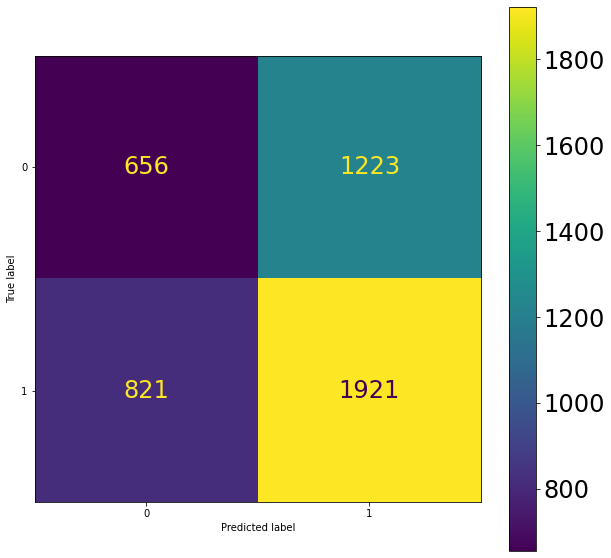

In [ ]:
# IE Model
y_train_ie = df_train["IE"]
y_val_ie = df_val["IE"]
y_test_ie = df_test["IE"]

ie_model, ie_accuracy, ie_predict = train_binary_classifier(y_train_ie, y_test_ie)

In [ ]:
# Gets the proportion of NS within each group for train dataset.
df_train.groupby("NS").count() / df_train.count()

,IE,JP,NS,TF,Unnamed: 0,mbti,movie_clean,role,text
NS,,,,,,,,,
0,0.526594,0.526594,NaN,0.526594,0.526594,0.526594,0.526594,0.526594,0.526616
1,0.473406,0.473406,NaN,0.473406,0.473406,0.473406,0.473406,0.473406,0.473384


In [ ]:
# Gets the proportion of NS within each group for test dataset.
df_test.groupby("NS").count() / df_test.count()

,IE,JP,NS,TF,Unnamed: 0,mbti,movie_clean,role,text
NS,,,,,,,,,
0,0.519801,0.519801,NaN,0.519801,0.519801,0.519801,0.519801,0.519801,0.519801
1,0.480199,0.480199,NaN,0.480199,0.480199,0.480199,0.480199,0.480199,0.480199


* Accuracy: 51.81%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


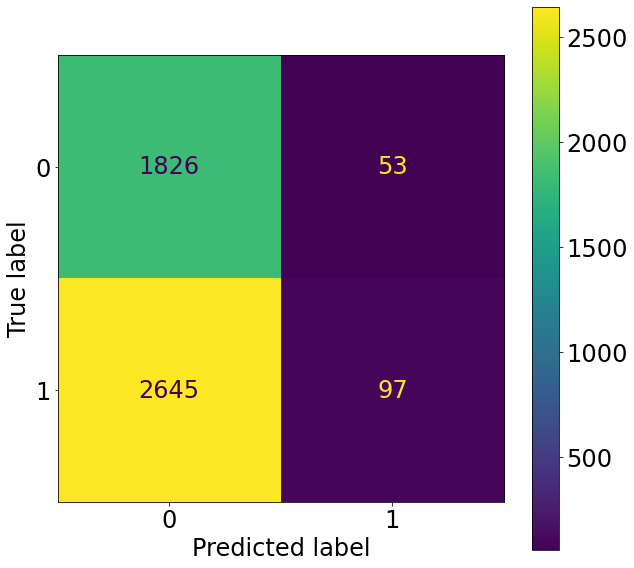

In [ ]:
# NS Model
y_train_ns = df_train["NS"]
y_val_ns = df_val["NS"]
y_test_ns = df_test["NS"]

ns_model, ns_accuracy, ns_predict = train_binary_classifier(y_train_ns, y_test_ns)

In [ ]:
# Gets the proportion of TF within each group for train dataset.
df_train.groupby("TF").count() / df_train.count()

,IE,JP,NS,TF,Unnamed: 0,mbti,movie_clean,role,text
TF,,,,,,,,,
0,0.597477,0.597477,0.597477,NaN,0.597477,0.597477,0.597477,0.597477,0.597508
1,0.402523,0.402523,0.402523,NaN,0.402523,0.402523,0.402523,0.402523,0.402492


In [ ]:
# Gets the proportion of TF within each group for test dataset.
df_test.groupby("TF").count() / df_test.count()

,IE,JP,NS,TF,Unnamed: 0,mbti,movie_clean,role,text
TF,,,,,,,,,
0,0.545337,0.545337,0.545337,NaN,0.545337,0.545337,0.545337,0.545337,0.545337
1,0.454663,0.454663,0.454663,NaN,0.454663,0.454663,0.454663,0.454663,0.454663


* Accuracy: 54.71%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


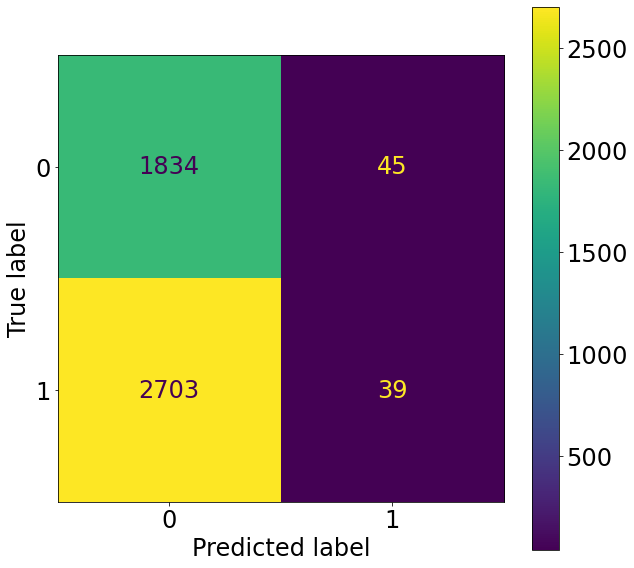

In [ ]:
# TF Model
y_train_tf = df_train["TF"]
y_val_tf = df_val["TF"]
y_test_tf = df_test["TF"]

tf_model, tf_accuracy, tf_predict = train_binary_classifier(y_train_tf, y_test_tf)

In [ ]:
# Gets the proportion of JP within each group for train dataset.
df_train.groupby("JP").count() / df_train.count()

,IE,JP,NS,TF,Unnamed: 0,mbti,movie_clean,role,text
JP,,,,,,,,,
0,0.599772,NaN,0.599772,0.599772,0.599772,0.599772,0.599772,0.599772,0.599745
1,0.400228,NaN,0.400228,0.400228,0.400228,0.400228,0.400228,0.400228,0.400255


In [ ]:
# Gets the proportion of JP within each group for test dataset.
df_test.groupby("JP").count() / df_test.count()

,IE,JP,NS,TF,Unnamed: 0,mbti,movie_clean,role,text
JP,,,,,,,,,
0,0.47111,NaN,0.47111,0.47111,0.47111,0.47111,0.47111,0.47111,0.47111
1,0.52889,NaN,0.52889,0.52889,0.52889,0.52889,0.52889,0.52889,0.52889


* Accuracy: 47.18%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


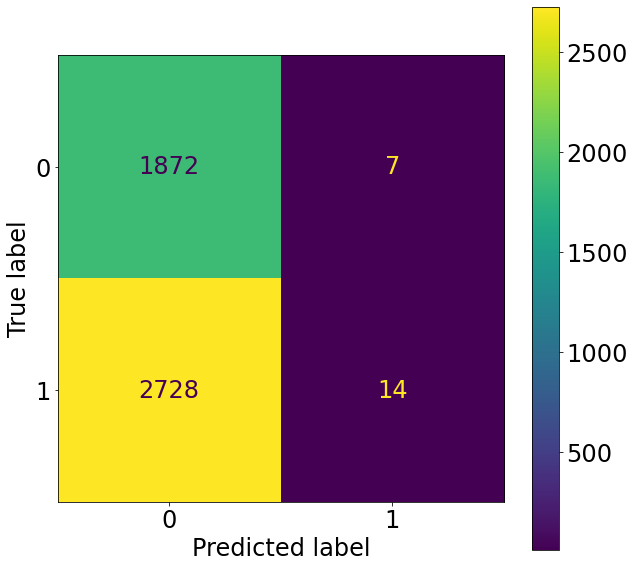

In [ ]:
# JP Model
y_train_jp = df_train["JP"]
y_val_jp = df_val["JP"]
y_test_jp = df_test["JP"]

jp_model, jp_accuracy, jp_predict = train_binary_classifier(y_train_jp, y_test_jp)

### Accuracy Values

In [ ]:
# Macroaverage accuracy of the four classifiers.
macroavg_accuracy = (ie_accuracy + jp_accuracy + ns_accuracy + tf_accuracy) / 4
print("* Macroaverage Accuracy: %.2f%%" % (macroavg_accuracy * 100.0))

* Macroaverage Accuracy: 52.36%


In [ ]:
# Microaverage accuracy of the four classifiers.
microavg_accuracy = ((645+1947)+(1874+13)+(1823+119)+(1833+40)) / (4*len(df_test))
print("* Microaverage Accuracy: %.2f%%" % (microavg_accuracy * 100.0))

* Microaverage Accuracy: 44.87%


In [ ]:
df_results = df_test

df_results["IE_pred"] = ie_model.predict(X_test)
df_results["NS_pred"] = ns_model.predict(X_test)
df_results["TF_pred"] = tf_model.predict(X_test)
df_results["JP_pred"] = jp_model.predict(X_test)

full_match = df_results[(df_results["IE"] == df_results["IE_pred"]) & (df_results["NS"] == df_results["NS_pred"]) & (df_results["TF"] == df_results["TF_pred"]) & (df_results["JP"] == df_results["JP_pred"])].count()["text"]
print("* Full Match Accuracy: %.2f%%" % (full_match/len(df_test) * 100.0))

* Full Match Accuracy: 5.63%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row